> Autor: Fabian Massotto

---

## Objetivo
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: "focus_video.mov"

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain" y realizar tres experimentos:
    - Medición sobre todo el frame.
    - Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    - Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames donde se detecta la condición de máximo enfoque.

2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

El algoritmo de detección a implementar debe detectar y devolver los puntos de máximo enfoque de manera automática.

__Puntos extra__: Aplicar unsharp masking para expandir la zona de enfoque y devolver.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def image_quality_measure(image):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicamos la Transformada de Fourier
    f = np.fft.fft2(gray_image)
    
    # Shifteamos al centro
    fc = np.fft.fftshift(f)
    
    # Calculamos el valor absoluto de la transformada de Fourier centrada
    af = np.abs(fc)

    # Encontramos el valor máximo de los componentes de frecuencia
    m = np.max(af)
    
    # Calculamos el umbral y el número total de píxeles que superan el umbral
    thres = m / 1000
    th = np.sum(af > thres)

    # Paso 6: Calcular la métrica de calidad de imagen (FM)
    img_quality = th / (image.shape[0] * image.shape[1])
    
    return img_quality

#### Medición sobre todo el frame

In [3]:
def whole_frame_experiment(video, algorithm):
    captura_video = cv2.VideoCapture(video)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        best_quality = 0
        quality_by_frame = []

        # Obtenemos el frame rate del video
        fps = int(captura_video.get(cv2.CAP_PROP_FPS))
        delay = int(1000 / fps)
        
        while True:
            ret, frame = captura_video.read()
            
            # Salir si termina el video
            if not ret:
                break

            # Aplico el algoritmo
            frame_quality = algorithm(frame)

            # Guardo el valor para graficarlo despues
            quality_by_frame.append(frame_quality)

            # Analizo si es mejor que el valor actual
            if frame_quality > best_quality:
                best_quality = frame_quality
            
            # Mostrar el frame
            cv2.imshow('Video', frame)
            
            # Salir del loop si se presiona la tecla 'q'
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficamos la curva del algoritmo
    plt.figure(figsize=(10, 5))
    plt.plot(quality_by_frame)
    plt.grid(True, linewidth=0.5)
    plt.xlabel('Frame #', fontsize=10)
    plt.ylabel('Image Quality Measure', fontsize=10)
    plt.tick_params(axis='x', labelsize=9)
    plt.tick_params(axis='y', labelsize=9)
    plt.title('Medición sobre todo el frame', fontsize=12)
    plt.show()

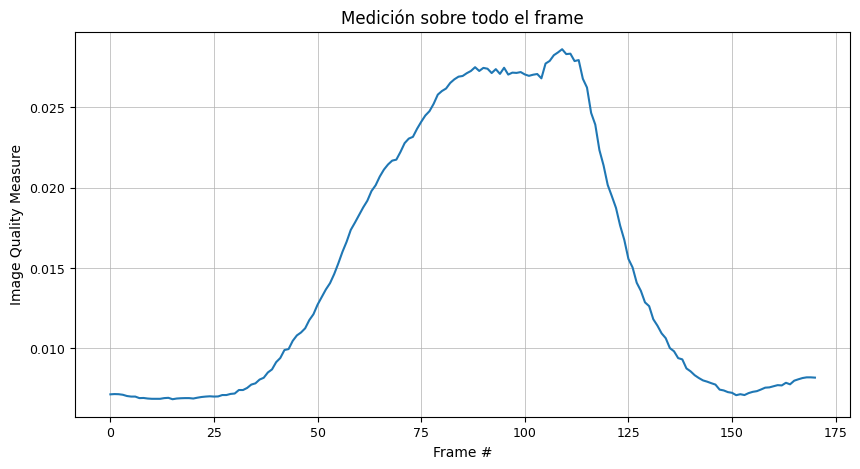

In [4]:
whole_frame_experiment('video/focus_video.mov', image_quality_measure)

#### Medición sobre una ROI

In [6]:
def get_roi(image, roi_percentage):
    # Obtenemos las dimensiones de la imagen
    h, w = image.shape[:2]  
    
    # Calculamos el área de la imagen
    area = h * w  
    
    # Calculamos el área de la ROI
    roi_area = area * (roi_percentage / 100)  
    
    # Calcular la longitud de los lados de la ROI (asumiendo un cuadrado)
    roi_size = int(np.sqrt(roi_area))
    
    # Coordenadas del centro de la imagen
    center_x, center_y = w // 2, h // 2
    
    # Coordenadas de la esquina superior izquierda de la ROI
    x_start = center_x - roi_size // 2
    y_start = center_y - roi_size // 2
    
    # Extraer la ROI
    roi = image[y_start:y_start + roi_size, x_start:x_start + roi_size]
    
    return roi, (x_start, y_start, x_start+roi_size, y_start+roi_size)

In [24]:
def roi_experiment(video, algorithm, roi_percentage):
    captura_video = cv2.VideoCapture(video)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        best_quality = 0
        quality_by_frame = []

        # Obtenemos el frame rate del video
        fps = int(captura_video.get(cv2.CAP_PROP_FPS))
        delay = int(1000 / fps)
        
        # Hago una primera pasada para obtener el máximo enfoque
        while True:
            ret, frame = captura_video.read()
            
            # Salir si termina el video
            if not ret:
                break

            # Establecemos la ROI
            roi, coords = get_roi(frame, roi_percentage)

            # Aplico el algoritmo
            frame_quality = algorithm(roi)

            # Guardo el valor para graficarlo despues
            quality_by_frame.append(frame_quality)

            # Analizo si es mejor que el valor actual
            if frame_quality > best_quality:
                best_quality = frame_quality

        # Reseteamos el video
        captura_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_number = 0

        # Hago una segunda pasada para marcar en el video el momento de mejor enfoque  
        while True:
            ret, frame = captura_video.read()

            # Salir si termina el video
            if not ret:
                break
            
            # Como punto de mayor enfoque utilizo el 80 percentil de los valores obtenidos en el loop anterior
            best_focus_point = np.percentile(quality_by_frame, 80)

            # Seteo el color de la ROI en base al valor de calidad del frame
            roi_color = (0,0,255)
            frame_quality = quality_by_frame[frame_number]
            if frame_quality >= best_focus_point:
                roi_color = (0,255,0)
            
            # Dibujo la ROI
            cv2.rectangle(frame, (coords[0],coords[1]), (coords[2],coords[3]), roi_color, 2, cv2.LINE_AA)

            # Mostrar el frame
            cv2.imshow('Video', frame)

            frame_number += 1
            
            # Salir del loop si se presiona la tecla 'q'
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficamos la curva del algoritmo
    plt.figure(figsize=(10, 5))
    plt.plot(quality_by_frame)
    plt.grid(True, linewidth=0.5)
    plt.xlabel('Frame #', fontsize=10)
    plt.ylabel('Image Quality Measure', fontsize=10)
    plt.tick_params(axis='x', labelsize=9)
    plt.tick_params(axis='y', labelsize=9)
    plt.title('Medición sobre todo el frame', fontsize=12)
    plt.show()

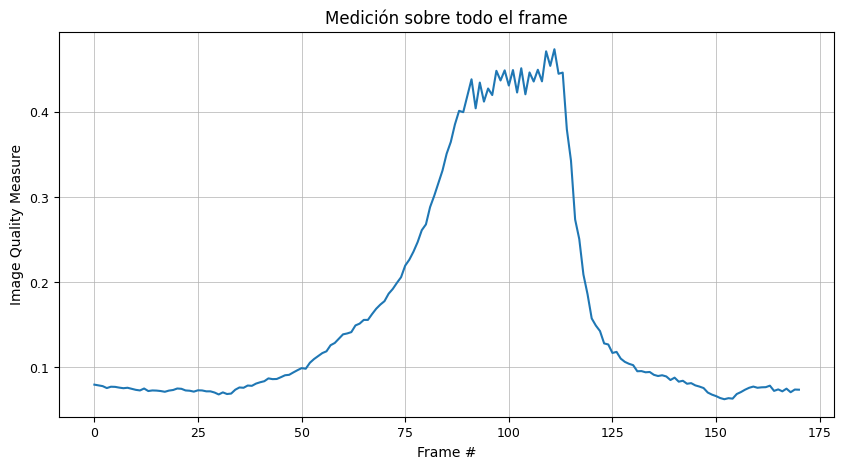

In [25]:
roi_experiment('video/focus_video.mov', image_quality_measure, 5)

#### Medición sobre una matriz de enfoque

In [8]:
def get_matrix(image, x, y):
    # Utilizo un tamaño fijo para los bloques de la matriz. 
    #  - Cada bloque tendrá un tamaño de 10x10 px
    #  - La separación entre bloques será de 10 px
    block_px = 20
    space_px = 20

    # Obtenemos las dimensiones de la imagen
    h, w = image.shape[:2]  
    
    # Coordenadas del centro de la imagen
    center_x, center_y = w // 2, h // 2 
    
    # Calculamos los lados de la matriz
    matrix_x = x * block_px + (x-1) * space_px
    matrix_y = y * block_px + (y-1) * space_px
    
    # Coordenadas de la esquina superior izquierda de la ROI
    x_start = center_x - matrix_x // 2
    y_start = center_y - matrix_y // 2
    
    # Extraer la matriz
    matrix = []
    for i in range(y):
        row = []
        for j in range(x):
            row.append((image[y_start+i*(block_px+space_px):y_start+(i+1)*block_px+i*space_px, x_start+j*(block_px+space_px):x_start+(j+1)*block_px+j*space_px], ( x_start+j*(block_px+space_px), y_start+i*(block_px+space_px), x_start+(j+1)*block_px+j*space_px, y_start+(i+1)*block_px+i*space_px)))
        matrix.append(row)
    
    return matrix

In [9]:
def focus_matrix_experiment(video, algorithm, x, y):
    captura_video = cv2.VideoCapture(video)

    if not captura_video.isOpened():
        print("Error al abrir el archivo de video")
    else:
        best_quality = 0
        quality_by_frame = []

        # Obtenemos el frame rate del video
        fps = int(captura_video.get(cv2.CAP_PROP_FPS))
        delay = int(1000 / fps)
        
        # Hago una primera pasada para obtener el máximo enfoque
        while True:
            ret, frame = captura_video.read()
            
            # Salir si termina el video
            if not ret:
                break

            # Establecemos la matriz
            matrix = get_matrix(frame, x, y)

            # Aplico el algoritmo
            quality_list = []
            for row in matrix:
                for block in row:
                    quality_list.append(algorithm(block[0]))

            # Promedio los resultados de cada bloque de la matriz
            frame_quality = np.mean(quality_list)

            # Guardo el valor para graficarlo despues
            quality_by_frame.append(frame_quality)

            # Analizo si es mejor que el valor actual
            if frame_quality > best_quality:
                best_quality = frame_quality

        # Reseteamos el video
        captura_video.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_number = 0

        # Hago una segunda pasada para marcar en el video el momento de mejor enfoque  
        while True:
            ret, frame = captura_video.read()

            # Salir si termina el video
            if not ret:
                break

            # Seteo el color de la ROI en base al valor de calidad del frame
            # Considero el momento de mejor enfoque a partir de un 85% de la calidad máxima
            roi_color = (0,0,255)
            frame_quality = quality_by_frame[frame_number]
            if frame_quality >= best_quality * 0.85:
                roi_color = (0,255,0)
            
            # Dibujo la matriz
            for row in matrix:
                for block in row:
                    cv2.rectangle(frame, (block[1][0],block[1][1]), (block[1][2],block[1][3]), roi_color, 2, cv2.LINE_AA)

            # Mostrar el frame
            cv2.imshow('Video', frame)

            frame_number += 1
            
            # Salir del loop si se presiona la tecla 'q'
            if cv2.waitKey(delay) & 0xFF == ord('q'):
                break

    # Libera el objeto de captura de video y cierra todas las ventanas
    captura_video.release()
    cv2.destroyAllWindows()

    # Graficamos la curva del algoritmo
    plt.figure(figsize=(10, 5))
    plt.plot(quality_by_frame)
    plt.grid(True, linewidth=0.5)
    plt.xlabel('Frame #', fontsize=10)
    plt.ylabel('Image Quality Measure', fontsize=10)
    plt.tick_params(axis='x', labelsize=9)
    plt.tick_params(axis='y', labelsize=9)
    plt.title('Medición sobre todo el frame', fontsize=12)
    plt.show()

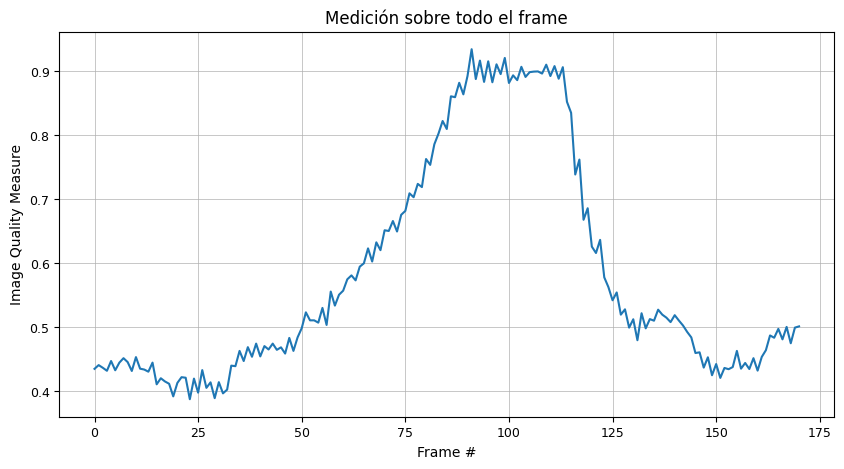

In [10]:
# Matriz de 3x3
focus_matrix_experiment('video/focus_video.mov', image_quality_measure, 3, 3)

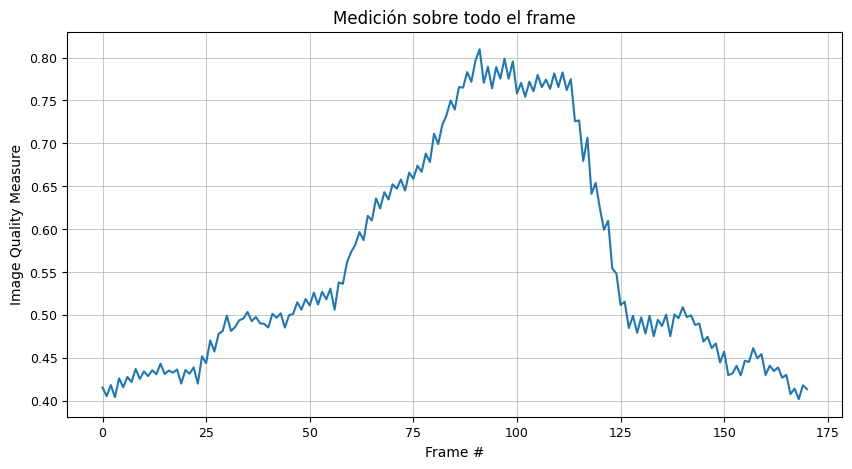

In [11]:
# Matriz de 7x5
focus_matrix_experiment('video/focus_video.mov', image_quality_measure, 7, 5)

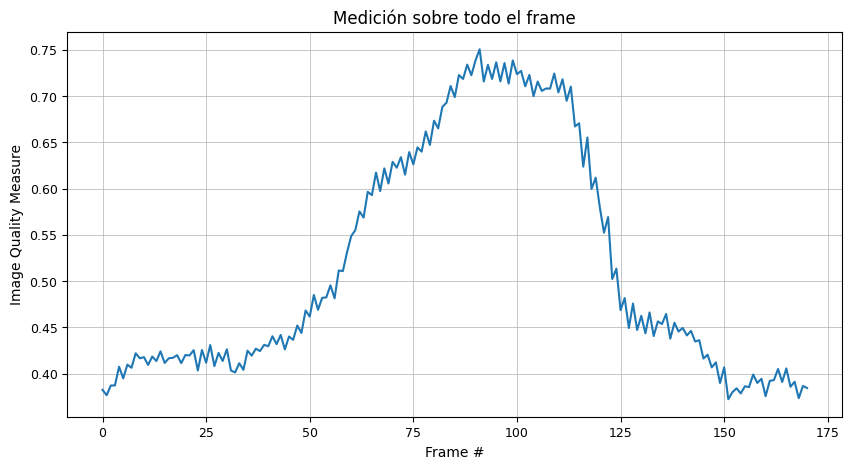

In [12]:
# Matriz de 5x7
focus_matrix_experiment('video/focus_video.mov', image_quality_measure, 5, 7)

#### Otra métrica de enfoque: Helmli and Scherer's mean method

Helmli and Scherer proposed to measure the local contrast by computing the ratio, Rðx,yÞ, between the intensity level of every pixel Iðx,yÞ and the mean gray level of its

In [19]:
def helmli_scherer_mean(image):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Para el kernel uso una ventana de 3x3
    window_size = 3

    # Reemplazo los pixeles que son 0 en la imagen en escala de grises por 1,
    # lo cual me permite evitar que el numerador sea 0 más adelante en el calculo del ratio
    # mientras que el cambio en la intensidad es mínimo
    gray_image[gray_image == 0] = 1
    
    # Construimos el kernel a partir de una matriz de unos y luego dividiendo cada elemento por la cantidad total,
    # obteniendo así un flitro promediado.
    kernel = np.ones((window_size, window_size), np.float32) / (window_size * window_size)
    
    # Aplicamos el kernel. El resultado es una nueva imagen en la que cada píxel 
    # contiene el valor promedio de los píxeles en su vecindario original definido por el kernel.
    local_mean = cv2.filter2D(gray_image, -1, kernel)
    
    # Calculamos el ratio R(x, y)
    ratio = np.where(local_mean < gray_image, gray_image / local_mean, local_mean / gray_image)
    
    # Calculamos la métrica de enfoque como la suma de los valores de R(x, y)
    focus_metric = np.sum(ratio)
    
    return focus_metric

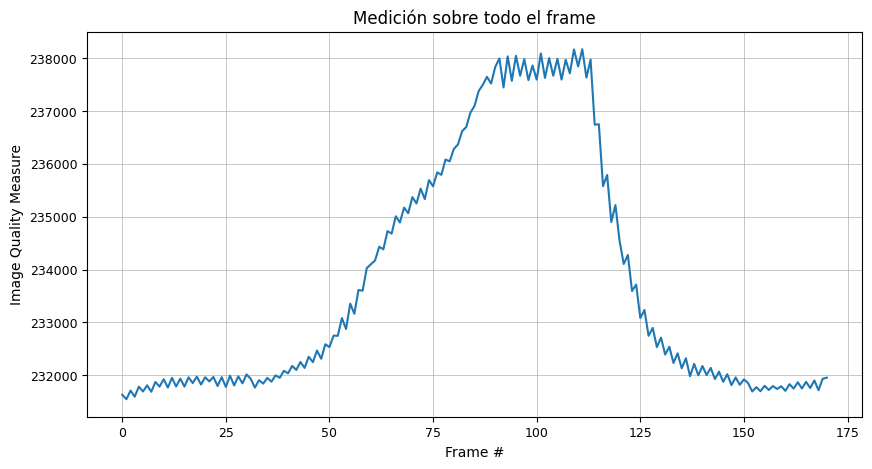

In [20]:
whole_frame_experiment('video/focus_video.mov', helmli_scherer_mean)

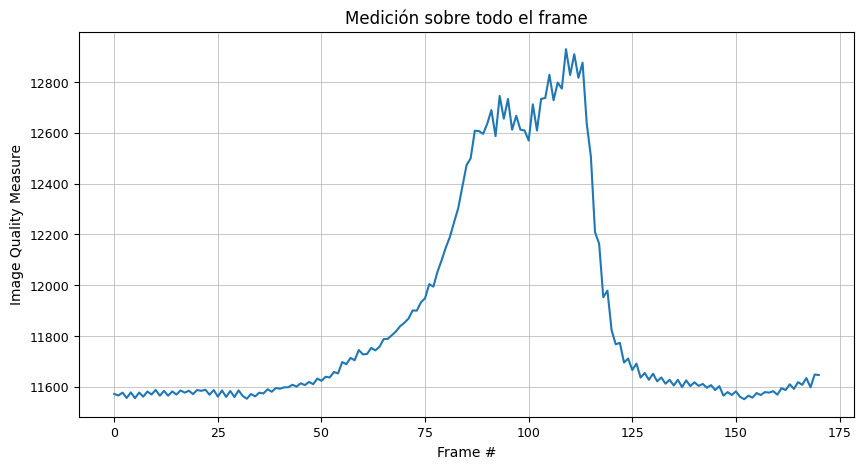

In [26]:
roi_experiment('video/focus_video.mov', helmli_scherer_mean, 5)